In [1]:
# import Pkg
# Pkg.add("CSV")
# Pkg.add("DataFrames")
# Pkg.add("DataFramesMeta")
# Pkg.add("JuMP")
# Pkg.add("Gurobi")
# Pkg.add("Distances")
# Pkg.add("Random")
# Pkg.add("Distributions")
# Pkg.add("Statistics")
# Pkg.add("Graphs")
# Pkg.add("GraphPlot")
# Pkg.add("MultiObjectiveAlgorithms")
# Pkg.add("Compose")
# Pkg.add("Cairo")
# Pkg.add("Colors")
# Pkg.add("Fontconfig")
# Pkg.add("Leaflet")
# Pkg.add("GeoInterface")

In [2]:
using Plots
using Compose, Cairo, Fontconfig

In [30]:
include("./src/utils.jl")
include("./src/data.jl")
include("./src/opt.jl")
include("./src/out.jl")
include("./src/lagrange.jl")
include("./src/metrics.jl");

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-23


In [4]:
trips, shapes = loadGTFS("..\\data\\Nanaimo-GTFS");

In [9]:
# subset = subsetGTFS(trips, 9, randomSeed = 12) # good example
# subset = subsetGTFS(trips, 10, randomSeed = 12) # good example
subset = subsetGTFS(trips, 20, randomSeed = 2); # good example for mapping
# subset = subsetGTFS(trips, 10, randomSeed = 10)
instance = VSPInstance(subset);
vsp_model = VSPModel(instance; numScenarios = 100, warmStart = false, isInt = true, multiObj = false)
# vsp_model_nonint = VSPModel(instance; isInt = false, multiObj = false)
# mcf_model = MCFModel(instance)
vsp_solution = solve!(vsp_model);
# vsp_solution_nonint = solve!(vsp_model_nonint)
# mcf_solution = solve!(mcf_model);

numTrips = 20
numVehicles = 5.0
isInt = true
termination_status(mod.model) = MathOptInterface.OPTIMAL
objective_value(mod.model) = 562.605406616624
solve_time(mod.model) = 1.878000020980835


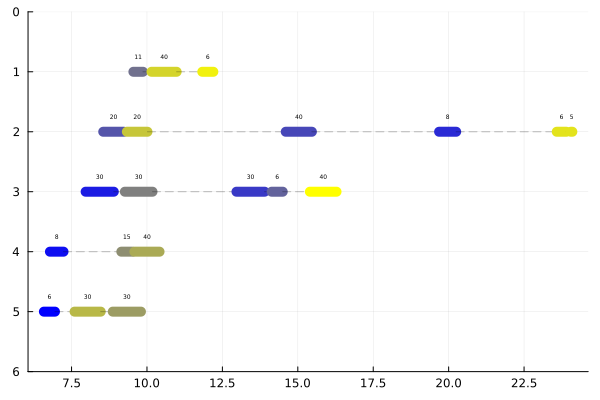

In [31]:
plotVSP_time(vsp_solution)

In [26]:
vsp_stats = getSolutionStats(vsp_solution, shapes).metrics
vsp_stats[:, Not("geometry")]

Row,duration,num_trips,utilization,propagated_delay,trip_distance
,Float64,Int64,Float64,Float64,Float64
1,2.65,3,0.572327,0.0,3.0063e6
2,15.55,6,0.203644,0.111898,7.62671e6
3,8.31667,5,0.48497,0.145052,1.11097e7
4,3.63333,3,0.454129,0.0304587,3.87788e6
5,3.21667,3,0.673575,0.00105434,5.92216e6


In [6]:
# draw(PNG(".\\imgs\\VSP-PD-$(instance.n-1)-instance.png", 16cm, 16cm), plotVSP(instance))
# draw(PNG(".\\imgs\\VSP-PD-$(instance.n-1)-mcf_solution.png", 16cm, 16cm), plotVSP(mcf_solution))
# draw(PNG(".\\imgs\\VSP-PD-$(instance.n-1)-mcf_solution.png", 16cm, 16cm), plotVSP(vsp_solution_nonint))

## Leaflet

In [9]:
plotVSP_map(vsp_stats)

Leaflet.Map{Vector{Leaflet.Layer}, Leaflet.Config{Leaflet.Provider}, WebIO.Scope}(Leaflet.Layer[Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Tuple{Float64, Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Tuple{Float64, Float64}}, Nothing, Nothing}([(-124.11857, 49.24773), (-124.11872, 49.24791), (-124.11423, 49.24794), (-124.11379, 49.24785), (-124.11324, 49.24738), (-124.1128, 49.24754), (-124.11118, 49.24758), (-124.10787, 49.2476), (-124.10566, 49.24761), (-124.10406, 49.24769)  …  (-124.04819, 49.23446), (-124.0482, 49.235), (-124.04898, 49.23501), (-124.04956, 49.23471), (-124.04988, 49.23471), (-124.05248, 49.23635), (-124.05296, 49.23615), (-124.05366, 49.2366), (-124.05327, 49.23685), (-124.05263, 49.23638)], nothing, nothing), Dict{Symbol, Any}(:color => "#FF0000", :border_width => 2.0, :opacity => 0.5, :color_map => "nothing", :fill_opacity => 0.5, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Tuple{Float64, Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Tuple{Float64, Float64}}, Nothing, Nothing}([(-124.05263, 49.23638), (-124.05336, 49.23695)], nothing, nothing), Dict{Symbol, Any}(:color => "#FF0000", :border_width => 2.0, :opacity => 0.5, :color_map => "nothing", :fill_opacity => 0.5, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Tuple{Float64, Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Tuple{Float64, Float64}}, Nothing, Nothing}([(-124.05336, 49.23695), (-124.05365, 49.23715), (-124.05339, 49.23795), (-124.05296, 49.23823), (-124.05347, 49.23854), (-124.05402, 49.23871), (-124.05475, 49.2388), (-124.05422, 49.24012), (-124.05394, 49.24083), (-124.05388, 49.24176)  …  (-123.93352, 49.16575), (-123.93308, 49.16589), (-123.93274, 49.16589), (-123.93219, 49.16566), (-123.93175, 49.16528), (-123.93149, 49.16523), (-123.93133, 49.16508), (-123.93125, 49.16481), (-123.93136, 49.16462), (-123.93233, 49.16385)], nothing, nothing), Dict{Symbol, Any}(:color => "#FF0000", :border_width => 2.0, :opacity => 0.5, :color_map => "nothing", :fill_opacity => 0.5, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Tuple{Float64, Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Tuple{Float64, Float64}}, Nothing, Nothing}([(-124.05336, 49.23695), (-123.96652, 49.15823)], nothing, nothing), Dict{Symbol, Any}(:color => "#FF0000", :border_width => 2.0, :opacity => 0.5, :color_map => "nothing", :fill_opacity => 0.5, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Tuple{Float64, Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Tuple{Float64, Float64}}, Nothing, Nothing}([(-123.96652, 49.15823), (-123.96677, 49.15838), (-123.96704, 49.15849), (-123.96713, 49.15885), (-123.96679, 49.15904), (-123.96419, 49.15902), (-123.9626, 49.15901), (-123.96119, 49.159), (-123.96113, 49.16003), (-123.961, 49.16129)  …  (-123.93574, 49.1634), (-123.93546, 49.16342), (-123.93517, 49.16331), (-123.93478, 49.16299), (-123.93319, 49.16321), (-123.93291, 49.16314), (-123.93208, 49.1639), (-123.93136, 49.16462), (-123.93113, 49.16442), (-123.93168, 49.16409)], nothing, nothing), Dict{Symbol, Any}(:color => "#FF0000", :border_width => 2.0, :opacity => 0.5, :color_map => "nothing", :fill_opacity => 0.5, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Tuple{Float64, Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Tuple{Float64, Float64}}, Nothing, Nothing}([(-123.93233, 49.16385), (-123.96652, 49.15823)], nothing, nothing), Dict{Symbol, Any}(:color => "#FF0000", :border_width => 2.0, :opacity => 0.5, :color_map => "nothing", :fill_opacity => 0.5, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineStrin

## Bender's decomposition

In [9]:
# fs = FirstStageProblem(instance; timeLimit = 10)
# add_benders_callback!(fs)
# bd_solution = solve!(fs);
# @show mean(lp_callback_runtimes)
# @show mean(get_p_callback_runtimes);
# MOI.get(fs.model, MOI.RelativeGap())
# plotVSP(bd_solution)

## 10 sec Opt Gap

In [11]:
# instance_sizes = 100:100:500
# opt_gap_IP = []
# opt_gap_BD = []

# for size in instance_sizes
#     sum_IP = 0
#     sum_BD = 0
#     for i in 1:5
#         subset = subsetGTFS(trips, size, randomSeed = i)
#         instance = VSPInstance(subset)
#         model_IP = VSPModel(instance, isInt = true, multiObj = false, timeLimit = 10)
#         model_BD = FirstStageProblem(instance, timeLimit = 10)
#         add_benders_callback!(model_BD)
#         sol_IP = solve!(model_IP);
#         sol_BD = solve!(model_BD);
#         sum_IP += MOI.get(model_IP.model, MOI.RelativeGap())
#         sum_BD += MOI.get(model_BD.model, MOI.RelativeGap())
#     end
#     push!(opt_gap_IP, sum_IP / 5)
#     push!(opt_gap_BD, sum_BD / 5)
# end
@show [opt_gap_IP opt_gap_BD]

[opt_gap_IP opt_gap_BD] = [6.031947682607448e-6 0.1629275916113045; 0.027256919099971622 0.47132052625010956; 0.526180825699331 0.768839649480148; 0.7067324202226736 0.8463141117589137]


4×2 Matrix{Float64}:
 6.03195e-6  0.162928
 0.0272569   0.471321
 0.526181    0.76884
 0.706732    0.846314

## Lagrange relaxation

In [51]:
LR = LagrangeRelaxation(instance)

for i ∈ 1:100
    status = update!(LR)
    if status
        println(i)
        break
    end
end

Solution found within 1% optimality gap.
3


In [60]:
# plot([LR.UB LR.LB])
# hline!([objectiveValue(vsp_solution.x, vsp_solution.s, instance.C, instance.M)])
# plot(LR.opt_gap, ylims = [0, 1])
# LR.λ
# println(
#     "vsp: ",
#     sum(LR.x[LR.best_idx[1]] .+ vsp_solution.x .> 1) / sum(vsp_solution.x),
#     "; mcf: ",
#     sum(LR.x[LR.best_idx[1]] .+ mcf_solution.x .> 1) / sum(mcf_solution.x)
# )
# (minimum(LR.UB) .- objective_value(vsp_model.model)) ./ objective_value(vsp_model.model)
# (LR.UB[1] .- objective_value(vsp_model.model)) ./ objective_value(vsp_model.model)
# LR.s_adj
# plotVSP(instance, LR.x[LR.best_idx[1]], LR.s_adj[LR.best_idx[1]])

## solve times

In [8]:
# solve times
# instance_sizes = 20:20:200
# sol_times_LP = []
# sol_times_IP = []
# sol_times_BD = []

# for size in instance_sizes
#     sum_LP = 0
#     sum_IP = 0
    # sum_BD = 0
    # for i in 1:5
    #     subset = subsetGTFS(trips, size, randomSeed = i)
    #     instance = VSPInstance(subset)
    #     model_LP = VSPModel(instance, isInt = false, multiObj = false)
    #     model_IP = VSPModel(instance, isInt = true, multiObj = false)
        # model_BD = FirstStageProblem(instance)
        # add_benders_callback!(model_BD)
        # sol_LP = solve!(model_LP);
        # sol_IP = solve!(model_IP);
        # sol_BD = solve!(model_BD);
        # sum_LP += sol_LP.solve_time
        # sum_IP += sol_IP.solve_time
        # sum_BD += sol_BD.solve_time
    # end
    # push!(sol_times_LP, sum_LP / 5)
    # push!(sol_times_IP, sum_IP / 5)
    # push!(sol_times_BD, sum_BD / 5)
# end
# plot(
#     instance_sizes,
#     [sol_times_LP sol_times_IP];
#     xlabel = "number of trips",
#     ylabel = "solve time",
#     title = "LP, and IP solution times",
#     label = ["LP" "IP"]
# )
# png(".\\imgs\\VSP-PD-solve_times-BD")

## Pareto frontier

In [29]:
# Pareto frontier
# mod = vsp_model.model
# used_vehicles = [round(sum(value.(vsp_model.x[1, :]; result = i)); digits = 3) for i in 1:result_count(mod)]
# ideal_point = objective_bound(mod)
# pareto_plot = hline([ideal_point[2]]; color = :red, lw = 2, label = "", ylims = [1300, 1600], xlims = [-0.2, 7])
# vline!([ideal_point[1]]; color = :red, lw = 2, label = "objective bounds")
# Plots.scatter!(
#     [objective_value(mod; result = i)[1] for i in 1:result_count(mod)],
#     [objective_value(mod; result = i)[2] for i in 1:result_count(mod)];
#     xlabel = "delay",
#     ylabel = "cost",
#     title = "# trips: $(instance.n-1)",
#     label = "fleet used",
# )
# for i in 1:result_count(mod)
#     y = objective_value(mod; result = i)
#     Plots.annotate!(y[1], y[2] + 10, (used_vehicles[i], 10))
# end
# png(".\\imgs\\VSP-PD-$(instance.n-1)-pareto")
# pareto_plot